In [68]:
from implementations import *
from proj1_helpers import *

import numpy as np
import random
from tqdm import tqdm_notebook

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
%autoreload 2

In [3]:
LOWER_BOUND = -1
UPPER_BOUND = 1

# Import data

In [4]:
DATA_FOLDER = "competition-data/"
DATA_TEST = "test.csv"
DATA_TRAIN = "train.csv"

y_train, x_train, ids_train = load_csv_data(DATA_FOLDER + DATA_TRAIN, LOWER_BOUND, UPPER_BOUND)
y_test, x_test, ids_test = load_csv_data(DATA_FOLDER + DATA_TEST, LOWER_BOUND, UPPER_BOUND)

In [76]:
tx_train = x_train.T
tx_test = x_test.T

In [77]:
tx_train

array([[ 138.47 ,  160.937,      nan, ...,  105.457,   94.951,      nan],
       [  51.655,   68.768,  162.172, ...,   60.526,   19.362,   72.756],
       [  97.827,  103.235,  125.953, ...,   75.839,   68.812,   70.831],
       ..., 
       [   1.24 ,      nan,      nan, ...,      nan,      nan,      nan],
       [  -2.475,      nan,      nan, ...,      nan,      nan,      nan],
       [ 113.497,   46.226,   44.251, ...,   41.992,    0.   ,    0.   ]])

# Cleaning data

In [78]:
tx_train, idx_to_del = delete_features(tx_train, 0.7)
tx_test = delete_features_from_idx(tx_test, idx_to_del)
tx_train.shape
tx_test.shape

(23, 568238)

In [79]:
print(idx_to_del)

[4, 5, 6, 12, 26, 27, 28]


In [80]:
tx_train = replace_nan_by_median(tx_train)
tx_test = replace_nan_by_median(tx_test)

In [81]:
mean_train, std_train, tx_train = standardize(tx_train)
tx_test = standardize_predef(tx_test, mean_train, std_train)

In [82]:
#tx_train = min_max(tx_train)

In [83]:
tx_train, y_train = balance(tx_train.T, y_train, LOWER_BOUND, UPPER_BOUND)

In [84]:
tx_train
tx_train.shape

(23, 171334)

# Cross Validation for Ridge Regression

In [59]:
model = "ridge_regression"
seed = 3
k_fold = 10
k_indices = build_k_indices(y_train, k_fold, seed)
degrees = np.arange(1, 13, 1)
lambdas = np.logspace(-4, -1, 10)
gammas = [0]
max_iters = 0

def cross_validation_demo(model, k_fold, k_indices, degrees, lambdas, gammas, max_iters, tx_train, y_train):
    results = []
    for degree in tqdm_notebook(degrees):
        tx_poly = build_poly_tx(tx_train, degree)
        initial_w = init_w(tx_poly)
        for gamma in gammas:
            for lambda_ in lambdas:
                accs = []
                ws = []
                for k in range(k_fold):
                    w_tr, acc = cross_validation(y_train, tx_poly.T, initial_w,
                                                 max_iters,  k_indices, k, gamma, lambda_, LOWER_BOUND, UPPER_BOUND, model)
                    ws.append(w_tr)
                    accs.append(acc)
                w_final = np.mean(ws, axis=0)
                acc_mean = np.mean(accs)
                results.append((degree, gamma, lambda_, acc_mean))

                print("Finished: " + str((degree, gamma, lambda_, acc_mean)))
    
    print(results)
    
    best_degree, best_gamma, best_lambda, best_acc_mean = max(results, key=lambda x: x[3])
    print("Best accuracy: ",best_acc_mean)
    print("Best degree: ", best_degree)
    print("Best gamma: ", best_gamma)
    print("Best lambda: ", best_lambda)
    
    return results

results = cross_validation_demo(model, k_fold, k_indices, degrees, lambdas, gammas, max_iters, tx_train, y_train)

Finished: (1, 0, 0.0001, 0.49562831961711318)
Finished: (1, 0, 0.00021544346900318845, 0.49552325920737755)
Finished: (1, 0, 0.00046415888336127773, 0.49564582968540244)
Finished: (1, 0, 0.001, 0.49558746279110483)
Finished: (1, 0, 0.0021544346900318821, 0.4957742368528571)

Finished: (1, 0, 0.0046415888336127772, 0.49582676705772488)
Finished: (1, 0, 0.01, 0.49590848070974147)
Finished: (1, 0, 0.021544346900318822, 0.49562831961711318)
Finished: (1, 0, 0.046415888336127774, 0.49582093036829511)
Finished: (1, 0, 0.10000000000000001, 0.49547072900250982)
Finished: (2, 0, 0.0001, 0.49655635323644426)
Finished: (2, 0, 0.00021544346900318845, 0.49657969999416329)
Finished: (2, 0, 0.00046415888336127773, 0.49652133309986574)
Finished: (2, 0, 0.001, 0.49640459931127073)
Finished: (2, 0, 0.0021544346900318821, 0.49647463958442761)
Finished: (2, 0, 0.0046415888336127772, 0.49666725033560966)
Finished: (2, 0, 0.01, 0.49669059709332863)
Finished: (2, 0, 0.021544346900318822, 0.49684235101850227)

# Performance

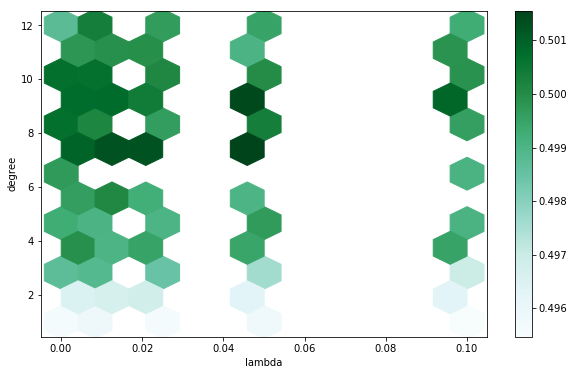

In [60]:
import pandas as pd

# show the best results for different parameters of the ridge regression
def show_ridge_results(results, l_degrees):

    df = pd.DataFrame.from_records(results, columns=['degree', 'gamma', 'lambda', 'acc'])
    df.plot.hexbin(x='lambda', y='degree', C='acc', gridsize=l_degrees, figsize=(10,6), sharex=False)
    plt.show()
    
    return df
    
df = show_ridge_results(results, len(degrees))

In [85]:
results.

(1, 0, 0.0001, 0.49562831961711318)

# Selecting best parameters

In [104]:
def compute_raw_predictions(results, degrees, tx, y):
    y_raw_preds = []
    ws = []
    for d in degrees:
        r_d = [r for r in results if r[0] == d]
        degree, gamma, lambda_, acc_mean = max(r_d, key=lambda x: x[3])
        tx_poly = build_poly_tx(tx, d)
        w, l = ridge_regression(y, tx_poly, lambda_)
        ws.append(w)
        y_raw_pred = np.dot(tx_poly.T, np.array(w))
        y_raw_preds.append(y_raw_pred)
        
    return y_raw_preds, ws

y_raw_preds, ws = compute_raw_predictions(results, [9, 10, 11], tx_train, y_train)
y_raw_preds

[array([[-0.00352026],
       [ 0.00757566],
       [ 0.00840324],
       ..., 
       [-0.01714945],
       [-0.01379862],
       [-0.03001575]]), array([[-0.02223583],
       [ 0.01341186],
       [ 0.03224925],
       ..., 
       [-0.02417495],
       [-0.005271  ],
       [-0.00370654]]), array([[-0.01421966],
       [ 0.00199321],
       [ 0.02703966],
       ..., 
       [-0.01661811],
       [-0.01138632],
       [ 0.00774187]])]


In [109]:
y_raw_preds_mean = np.mean(y_raw_preds, axis=0)
y_raw_preds_mean

array([[-0.01332525],
       [ 0.00766024],
       [ 0.02256405],
       ..., 
       [-0.01931417],
       [-0.01015198],
       [-0.00866014]])

In [110]:
threshold = (UPPER_BOUND + LOWER_BOUND)/2
y_raw_preds_mean[np.where(y_raw_preds_mean <= threshold)] = -1
y_raw_preds_mean[np.where(y_raw_preds_mean > threshold)] = 1
print(y_raw_preds_mean)

[[-1.]
 [ 1.]
 [ 1.]
 ..., 
 [-1.]
 [-1.]
 [-1.]]


In [112]:
np.mean(y_train == y_raw_preds_mean)

0.51254858930509994

In [132]:
y_train

array([[ 1.],
       [ 1.],
       [ 1.],
       ..., 
       [-1.],
       [-1.],
       [-1.]])

In [137]:
tx = np.squeeze(y_preds, axis=2)
tx

array([[-0.00352026,  0.00757566,  0.00840324, ..., -0.01714945,
        -0.01379862, -0.03001575],
       [-0.02223583,  0.01341186,  0.03224925, ..., -0.02417495,
        -0.005271  , -0.00370654],
       [-0.01421966,  0.00199321,  0.02703966, ..., -0.01661811,
        -0.01138632,  0.00774187]])

In [138]:
w, l = least_squares(y_train, tx)

y_t = np.dot(tx.T, w)

np.mean(y_train == y_raw_preds_mean)

0.51254858930509994

In [141]:
model = "logistic_regression"
seed = 3
k_fold = 4
k_indices = build_k_indices(y_train, k_fold, seed)
degrees = [1]
lambdas = [0]
gammas = [0.7]
max_iters = 1000

def cross_validation_demo(model, k_fold, k_indices, degrees, lambdas, gammas, max_iters, tx_train, y_train):
    results = []
    for degree in tqdm_notebook(degrees):
        tx_poly = build_poly_tx(tx_train, degree)
        initial_w = init_w(tx_poly)
        for gamma in gammas:
            for lambda_ in lambdas:
                accs = []
                ws = []
                for k in range(k_fold):
                    w_tr, acc = cross_validation(y_train, tx_poly.T, initial_w,
                                                 max_iters,  k_indices, k, gamma, lambda_, LOWER_BOUND, UPPER_BOUND, model)
                    ws.append(w_tr)
                    accs.append(acc)
                w_final = np.mean(ws, axis=0)
                acc_mean = np.mean(accs)
                results.append((degree, gamma, lambda_, acc_mean))

                print("Finished: " + str((degree, gamma, lambda_, acc_mean)))
    
    print(results)
    
    best_degree, best_gamma, best_lambda, best_acc_mean = max(results, key=lambda x: x[3])
    print("Best accuracy: ",best_acc_mean)
    print("Best degree: ", best_degree)
    print("Best gamma: ", best_gamma)
    print("Best lambda: ", best_lambda)
    
    return results

results = cross_validation_demo(model, k_fold, k_indices, degrees, lambdas, gammas, max_iters, tx, y_train)

/Users/Joel/Drive/EPFL/MA1/github/CS-433/project1/implementations.py:118: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-t))
/Users/Joel/Drive/EPFL/MA1/github/CS-433/project1/implementations.py:125: RuntimeWarning: overflow encountered in exp
  exp_ = np.exp(tx.dot(w))


Finished: (1, 0.7, 0, 0.50035603389909655)

[(1, 0.7, 0, 0.50035603389909655)]
Best accuracy:  0.500356033899
Best degree:  1
Best gamma:  0.7
Best lambda:  0


# Predict labels

In [35]:
from proj1_helpers import predict_labels_kaggle

In [46]:
y_pred = predict_labels_kaggle(w_final, tx_test.T, LOWER_BOUND, UPPER_BOUND)

# Submission

In [47]:
from proj1_helpers import create_csv_submission

In [48]:
create_csv_submission(ids_test, y_pred, "test11.csv")

Test n : algorithm / features / y / w
- - - - - - - - - - - - - - - - - - - 
Test 1 : least_squares / all features standardized / y = -1,1 / random init_w

Test 2 : least_squares / corr > 0.1 features standardized / y = -1,1 / random init_w

Test 3 : least_squares_GD(10000,0.5) / all features standardized / y = -1,1 / random init_w

Test 4 : least_squares_GD(10000,0.5) / all features standardized / y = -1,1 / random init_w / poly, degree=1

Test 5 : least_squares / all features standardized / y = -1,1 / random init_w / median + categorical

Test 6 : logistic_regressoin  /all features standardized / y = 0,1 / random init_w / median + categorical + balanced

Test 7 : least_squares / all features standardized / y = 0,1 / random init_w

Test 8 : Test 1

Test 9 : Test 1

Test 10 : Test 1 / standardized test_set with mean and std from train_set

Test 11 : Test 1 / standardized test_set with mean and std from train_set / balance

## Further work

- balance output (batch numpy)
- median and category
- features engineering : features d'intéraction
- logistic regression 